**Look inside CNN**



* MNIST



In [1]:
import numpy as np
import torch
import torch.nn as nn # Conv2d, BatchNorm2d
import torch.nn.functional as F # F.softmax
import torchvision # To download dataset
import torchvision.transforms as transforms 
# dataset 전처리 (to tensor, rotate[data augmentation 데이터 증강])

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

1. Define Hyper-parameters and pre-set device on cuda

In [3]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 나중에 학습 전에 데이터를 gpu에 넣고 학습하기 위함 --> model과 데이터가 같은 device
## images.to(device) / model.to(device)

print(f"device: {device}")
# Adjust Dataset classes and channels
num_classes = 10
in_channel = 1 # RGB -> 3 gray -> 1

# Hyper-parameters
batch_size = 50
max_pool_kernel = 2
learning_rate = 0.0001 # 0.01 ~ 0.0001
num_epochs = 5 # Overfitting 주의 --> 해결책

device: cuda


2. Load Data

In [4]:
train_data = torchvision.datasets.MNIST(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

test_data = torchvision.datasets.MNIST(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor(),
                                       download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



3. Define Dataloader

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)             # torch 의 data loader를 그대로 불러와 사용

4. Define Model

In [7]:
class ConvNetStep(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNetStep, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(kernel_size=5, in_channels=in_channel, out_channels=16,  stride=1, padding=2),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    # fc1 직전의 data shape
    self.fc1 = nn.Linear(in_features=32*7*7, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=num_classes) # num_classes = 10

  def forward1(self, x):
    x = self.layer1(x)
    return x
  
  def forward2(self, x):
    x = self.layer2(x)
    return x

  def forward3(self, x):
    x = x.reshape(x.size(0),-1)
    return self.fc1(x)

  def forward4(self, x):
    return self.fc2(x)

  def forward(self, x):    # 실제 학습 시에는 이 함수만 사용
    x = self.layer1(x) # 1*28*28 -> 16*14*14
    x = self.layer2(x) # 16*14*14 -> 32*7*7 3차원

    x = F.relu(x)
    x = x.reshape(x.size(0),-1) # Batchsize*32*7*7 (3차원) -> Batchsize*1568 (1차원)
    x = F.relu(self.fc1(x)) # 1568 -> 120
    x = self.fc2(x) # 120 -> 10
    return x

model = ConvNetStep()

4.1 Inside CNN

4.1.1 Row Image (MNIST)

In [8]:
def image_show(tensor_image):
  image = tensor_image.reshape(tensor_image.size()[1], tensor_image.size()[2])    # width x height
  imshow(image, cmap='gray')

images, labels = next(iter(train_loader))
image1, label1 = images[0], labels[0]
image2, label2 = images[1], labels[1]

Text(0.5, 1.0, 'tensor(7)')

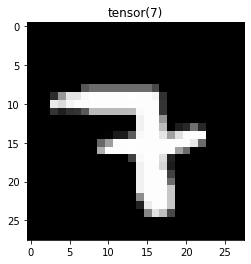

In [9]:
image_show(image1)
plt.title(label1)

Text(0.5, 1.0, 'tensor(1)')

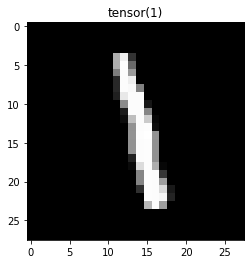

In [10]:
image_show(image2)
plt.title(label2)

4.1.2 After 1st convolution layer

In [11]:
model.eval()
output1 = model.forward1(images)
print(f"{images.size()} --> {output1.size()}")

torch.Size([50, 1, 28, 28]) --> torch.Size([50, 16, 14, 14])


In [12]:
image1, image2 = output1[0], output1[1]
print(image1.size(), image2.size())

torch.Size([16, 14, 14]) torch.Size([16, 14, 14])


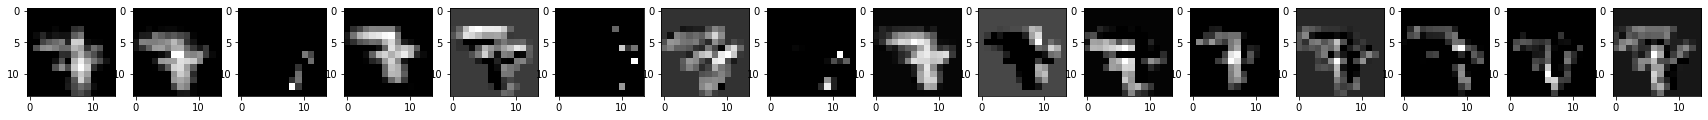

In [13]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
  plt.subplot(1,len(image1),i+1)
  plt.imshow(image1[i].detach().numpy(), cmap='gray')
# 14x14 그림 16개 (out channel)

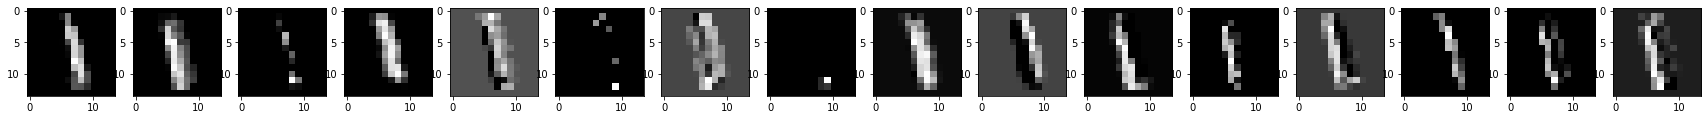

In [14]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
  plt.subplot(1,len(image2),i+1)
  plt.imshow(image2[i].detach().numpy(), cmap='gray')

4.1.3 After 2nd convolution layer

In [15]:
output2 = model.forward2(output1)
print(f"{output1.size()} --> {output2.size()}")

torch.Size([50, 16, 14, 14]) --> torch.Size([50, 32, 7, 7])


In [16]:
image1, image2 = output2[0], output2[1]

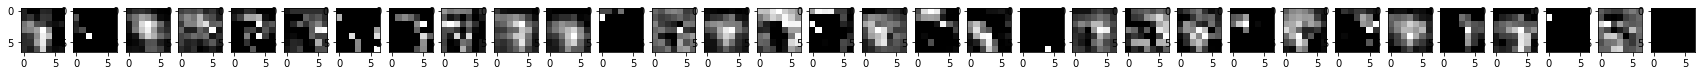

In [17]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image1)):
  plt.subplot(1,len(image1),i+1)
  plt.imshow(image1[i].detach().numpy(), cmap='gray')

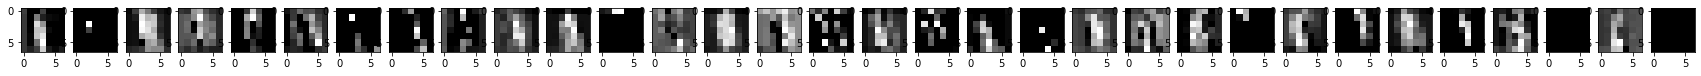

In [18]:
fig = plt.figure(figsize=(30,30))

for i in range(len(image2)):
  plt.subplot(1,len(image2),i+1)
  plt.imshow(image2[i].detach().numpy(), cmap='gray')

4.1.4 After 3rd Fully Connected Layer

In [19]:
output3 = model.forward3(output2)
print(f"{output2.size()} --> {output3.size()}")

torch.Size([50, 32, 7, 7]) --> torch.Size([50, 120])


In [20]:
image1, image2 = output3[0], output3[1]

print(image1.size(), image2.size())

torch.Size([120]) torch.Size([120])


TypeError: ignored

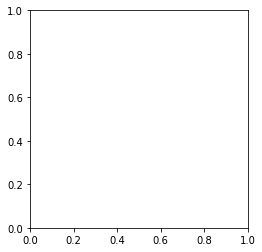

In [21]:

"""
  error : image1가 더 이상 2차원 tensor가 아님. (이미지로 show 불가)
"""
plt.imshow(image1[0].detach().numpy())

In [27]:
print(image1)

tensor([ 0.0354, -0.0661,  0.0006, -0.0037,  0.0550,  0.0123,  0.0810, -0.0517,
        -0.0530,  0.0386], grad_fn=<SelectBackward0>)


4.1.5 After 4th Fully Connectec Layer

In [24]:
output4 = model.forward4(output3)
print(f"{output3.size()} --> {output4.size()}")

torch.Size([50, 120]) --> torch.Size([50, 10])


In [25]:
image1, image2 = output4[0], output4[1]
print(image1.size())
print(image2.size())

torch.Size([10])
torch.Size([10])


In [26]:
print("image1")
print("the final tensor :", image1)
print("the result prediction:", image1.tolist().index(image1.max()))
print("the original label:", label1)

image1
the final tensor : tensor([ 0.0354, -0.0661,  0.0006, -0.0037,  0.0550,  0.0123,  0.0810, -0.0517,
        -0.0530,  0.0386], grad_fn=<SelectBackward0>)
the result prediction: 6
the original label: tensor(7)


In [28]:
print("image2")
print("the final tensor:", image2)
print("the result prediction:", image2.tolist().index(image2.max()))
print("the original label:", label2)

image2
the final tensor: tensor([ 0.0083, -0.0575,  0.0211,  0.0086,  0.0514,  0.0255,  0.0780, -0.0706,
        -0.0327,  0.0125], grad_fn=<SelectBackward0>)
the result prediction: 6
the original label: tensor(1)


**5. Set Loss & Optimizer**

In [29]:
model = ConvNetStep().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**6. Train**

In [30]:
total_step = len(train_loader) # 60000
total_loss = []
model.train()
for epoch in range(num_epochs):
  epoch_loss = []
  for i, (img, label) in enumerate(train_loader):
    # Assign Tensors to Configures Devices (gpu)
    img = img.to(device)
    label = label.to(device)

    # Forward propagation
    outputs = model(img) # 10개의 score

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.detach().cpu().numpy()) # loss
    # Print Loss
    if i % 10000 == 0 or (i+1)==len(train_loader):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
  total_loss.append(np.mean(epoch_loss))
  print(f"epoch{i} loss: {np.mean(epoch_loss)}")

Epoch [1/5], Step [1/1200], Loss: 2.3342
Epoch [1/5], Step [1200/1200], Loss: 0.1121
epoch1199 loss: 0.26649999618530273
Epoch [2/5], Step [1/1200], Loss: 0.1242
Epoch [2/5], Step [1200/1200], Loss: 0.0618
epoch1199 loss: 0.06752659380435944
Epoch [3/5], Step [1/1200], Loss: 0.0169
Epoch [3/5], Step [1200/1200], Loss: 0.0763
epoch1199 loss: 0.048014286905527115
Epoch [4/5], Step [1/1200], Loss: 0.0358
Epoch [4/5], Step [1200/1200], Loss: 0.0337
epoch1199 loss: 0.03876611590385437
Epoch [5/5], Step [1/1200], Loss: 0.0094
Epoch [5/5], Step [1200/1200], Loss: 0.0924
epoch1199 loss: 0.031803857535123825


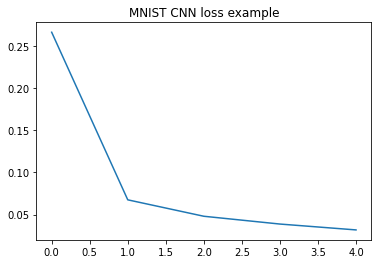

In [31]:
plt.plot(total_loss)
plt.title("MNIST CNN loss example")
plt.show()

**7. Save Model and Load Model to test**

7.1 Save model

In [32]:
torch.save(model.state_dict(),"my_model.pth")   # model의 weight 정보 만을 저장

7.2 Load model

In [35]:
test_model = ConvNetStep().to(device)

In [36]:
test_model.load_state_dict(torch.load("my_model.pth"))   # test_model이라는 모델 안에 앞서 학습한 weight 정보가 담기게 된다.

<All keys matched successfully>

In [37]:
test_model.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in test_loader:
    img = img.to(device)
    lab = lab.to(device)
    out = test_model(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

Accuracy of the network on the 10000 test images: 98.84%


In [38]:
correct

9884